In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.cluster import AgglomerativeClustering
from sklearn import manifold, decomposition, linear_model, ensemble, neighbors, cross_validation
%matplotlib inline
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import tqdm

from heamy.dataset import Dataset
from heamy.estimator import Regressor, Classifier
from heamy.pipeline import ModelsPipeline

/home/dima/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def rmse(x,y):
    return np.mean((x - y) ** 2) ** 0.5

## Подготовка данных (urls)

In [3]:
urls_train_df = pd.read_csv('data/url_domain_train', header=None, delimiter='\t')
urls_train_df.columns = ['id', 'url', 'count']
urls_train_df = urls_train_df[['id', 'url']]

In [4]:
urls_train_df.head()

,id,url
0,000000014B60815F65B38258011B6C01,login.rutracker.org
1,000000014B60815F65B38258011B6C01,rutracker.org
2,000000014C03DA2A47AC433A0C755201,admin.tour-spb.net
3,000000014C03DA2A47AC433A0C755201,czinfo.ru
4,000000014C03DA2A47AC433A0C755201,forumsostav.ru


In [5]:
urls_train_df = pd.DataFrame(urls_train_df.groupby('id')['url'].apply(lambda x: x.tolist()))
urls_train_df['id'] = urls_train_df.index
urls_train_df.index = range(len(urls_train_df))
urls_train_df.columns = ['urls', 'id']

In [6]:
urls_train_df.head()

,urls,id
0,"[id.rambler.ru, mail.rambler.ru, r0.ru]",000000013CB5719C0000A2C90002C101
1,"[1prime.ru, autorambler.ru, chellak.ru, docs.c...",00000001442BE24000001B7D00F50801
2,[bosch-korolev.ru],00000001448580F800003F1B31FB0901
3,"[aptekanizkihcen.ua, colady.ru, gorod.dp.ua, i...",0000000145BDB2FF000157971645E901
4,"[astrorok.ru, diets.ru, edaplus.info, eshzdoro...",000000014602771F0000DB9359714C01


In [7]:
age_train_df = pd.read_csv('data/age_profile_train', header=None, delimiter='\t')
age_train_df.columns = ['id', 'age']

In [8]:
age_train_df.head()

,id,age
0,000000013CB5719C0000A2C90002C101,53
1,00000001442BE24000001B7D00F50801,48
2,00000001448580F800003F1B31FB0901,28
3,0000000145BDB2FF000157971645E901,44
4,000000014602771F0000DB9359714C01,48


In [9]:
train_df = urls_train_df.merge(age_train_df, on='id', how='left')

In [10]:
train_df.tail()

,urls,id,age
118598,[dme.ru],E9B7BDD54E733BDF364DD7B4EF74CFEB,27
118599,"[aif.ru, autochel.ru, chelyabinsk.ru, id.rambl...",E9B9D7D347EB1ACE5AAEEBFCE3FBCE7B,58
118600,"[blog.partisani.ge, li.ru, tvrain.ru]",EBFAC66B4EE3FB96BA5DD7DDE3787FE7,56
118601,"[doctorkirov.ru, drive.ru, extrim-park43.ru, m...",F537AD6B46D31ABFF597EFDFE1BDDE71,31
118602,[samara.drom.ru],F55C7EDB467B9FAE1F97E7DDE1747F6B,35


In [11]:
title_unify_train = pd.read_csv('data/title_unify_train', header=None, delimiter='\t')
title_unify_train.columns = ['id','words','count']
title_unify_train = title_unify_train[['id','words']]

In [12]:
title_unify_train.tail()

,id,words
5850384,0625E40E56FB2B910000054E7CE27501,обозрение политический
5850385,0625E40E56FB2B910000054E7CE27501,обозрение политический страница
5850386,063915F15703D2CD000005362EDFB501,без вложение день заработок интернет рубль
5850387,063915F15703D2CD000005362EDFB501,бесплатный надёжный почта рамблер электронный
5850388,D79FBED94DD35ED75AADEDBC6D1CAFE7,март стих


In [13]:
title_unify_train = pd.DataFrame(title_unify_train.groupby('id')['words'].apply(lambda x: ' '.join(x)))
title_unify_train['id'] = title_unify_train.index
title_unify_train.index = range(len(title_unify_train))
title_unify_train.columns = ['words', 'id']

In [14]:
title_unify_train.head()

,words,id
0,бесплатный надёжный почта рамблер электронный ...,000000013CB5719C0000A2C90002C101
1,24-х 34-х до договор неделя новость предложить...,00000001442BE24000001B7D00F50801
2,авто бош контакт королёв сервис авто бош корол...,00000001448580F800003F1B31FB0901
3,ua втрать війни донбасі за на новини озвучить ...,0000000145BDB2FF000157971645E901
4,black walnut грецкий орех чёрный inmoment ru w...,000000014602771F0000DB9359714C01


In [15]:
train_df = train_df.merge(title_unify_train, on='id', how='left')

In [16]:
train_df.tail()

,urls,id,age,words
118598,[dme.ru],E9B7BDD54E733BDF364DD7B4EF74CFEB,27,NaN
118599,"[aif.ru, autochel.ru, chelyabinsk.ru, id.rambl...",E9B9D7D347EB1ACE5AAEEBFCE3FBCE7B,58,4z7616051a 4z7616051d 4z7616052a allroad arnot...
118600,"[blog.partisani.ge, li.ru, tvrain.ru]",EBFAC66B4EE3FB96BA5DD7DDE3787FE7,56,ru онлайн попка порно секс азербайджан военный...
118601,"[doctorkirov.ru, drive.ru, extrim-park43.ru, m...",F537AD6B46D31ABFF597EFDFE1BDDE71,31,5d merced-benz видео драйв комплектация отзыв ...
118602,[samara.drom.ru],F55C7EDB467B9FAE1F97E7DDE1747F6B,35,NaN


In [17]:
train_df = train_df[['id','urls','words','age']]

In [18]:
train_df.tail()

,id,urls,words,age
118598,E9B7BDD54E733BDF364DD7B4EF74CFEB,[dme.ru],NaN,27
118599,E9B9D7D347EB1ACE5AAEEBFCE3FBCE7B,"[aif.ru, autochel.ru, chelyabinsk.ru, id.rambl...",4z7616051a 4z7616051d 4z7616052a allroad arnot...,58
118600,EBFAC66B4EE3FB96BA5DD7DDE3787FE7,"[blog.partisani.ge, li.ru, tvrain.ru]",ru онлайн попка порно секс азербайджан военный...,56
118601,F537AD6B46D31ABFF597EFDFE1BDDE71,"[doctorkirov.ru, drive.ru, extrim-park43.ru, m...",5d merced-benz видео драйв комплектация отзыв ...,31
118602,F55C7EDB467B9FAE1F97E7DDE1747F6B,[samara.drom.ru],NaN,35


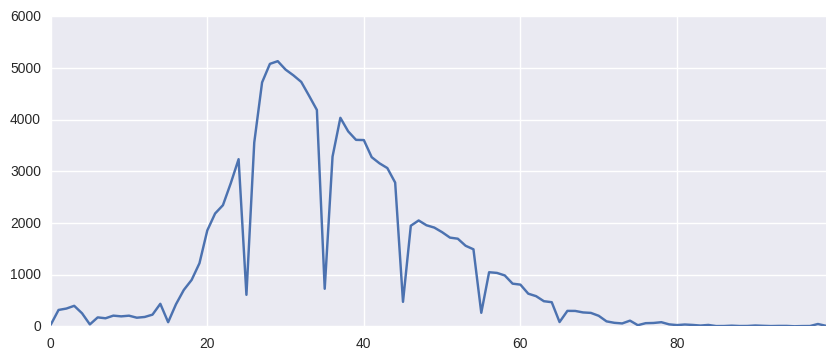

In [19]:
age_count = []
for age in xrange(100):
    age_count += [len(train_df[train_df.age == age])]
pd.Series(age_count).plot(figsize=(10,4))

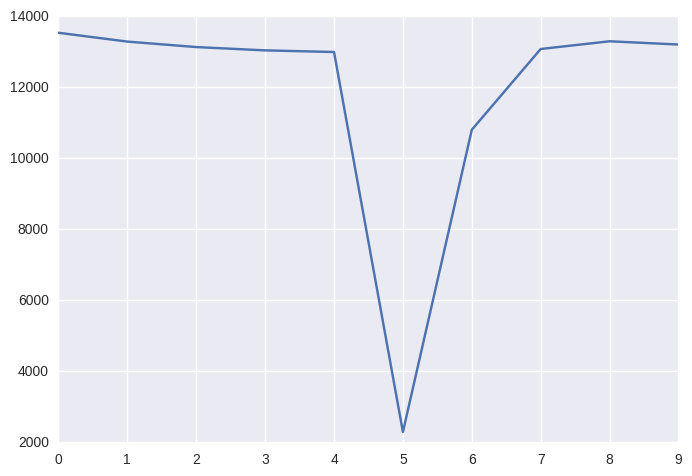

In [20]:
age_count = []
for i in xrange(10):
    age_count += [len(train_df[train_df.age % 10 == i])]
plt.plot(age_count)

In [21]:
train_df[train_df.age % 10 == 5].tail()

,id,urls,words,age
118148,0625E94F5702082200000543EDA15F01,"[anitokyo.tv, consultmill.ru, kakras.ru, mail....",formar terra аниме бесплатно онлайн смотреть т...,25
118257,06323A7556EA742B00000534ED7F9901,"[aktteva.ru, m.rambler.ru, mirtesen.ru, newss....",америка взбесить войско вывод почему будущее в...,45
118368,063905E556DFCF6D00000540B3121801,"[abonentov.net, chat.ru, gazeta.ru, gisclub.tv...",3g usb-модем для интернет мобильный gi прошивк...,55
118488,06392CA75702A7630000054E1849B501,"[d2bingo.ru, id.rambler.ru, mail.rambler.ru, m...",co rambler авторизация d2bingo ru дот испытать...,25
118602,F55C7EDB467B9FAE1F97E7DDE1747F6B,[samara.drom.ru],NaN,35


In [22]:
print(len(train_df[train_df.age >= 65]))
train_df = train_df[train_df.age < 65]

2254


In [23]:
print(len(train_df[train_df.age <= 15]))
train_df = train_df[train_df.age > 15]

3387


In [24]:
train_df.tail()

,id,urls,words,age
118598,E9B7BDD54E733BDF364DD7B4EF74CFEB,[dme.ru],NaN,27
118599,E9B9D7D347EB1ACE5AAEEBFCE3FBCE7B,"[aif.ru, autochel.ru, chelyabinsk.ru, id.rambl...",4z7616051a 4z7616051d 4z7616052a allroad arnot...,58
118600,EBFAC66B4EE3FB96BA5DD7DDE3787FE7,"[blog.partisani.ge, li.ru, tvrain.ru]",ru онлайн попка порно секс азербайджан военный...,56
118601,F537AD6B46D31ABFF597EFDFE1BDDE71,"[doctorkirov.ru, drive.ru, extrim-park43.ru, m...",5d merced-benz видео драйв комплектация отзыв ...,31
118602,F55C7EDB467B9FAE1F97E7DDE1747F6B,[samara.drom.ru],NaN,35


In [26]:
train_df = train_df[train_df.words == train_df.words]

## Снижение размерности

In [29]:
topk = 300000
X_urls, X_title, y = train_df.urls.values[:topk], train_df.words.values[:topk], train_df.age.values[:topk]
y = y - 36
y.size

108573

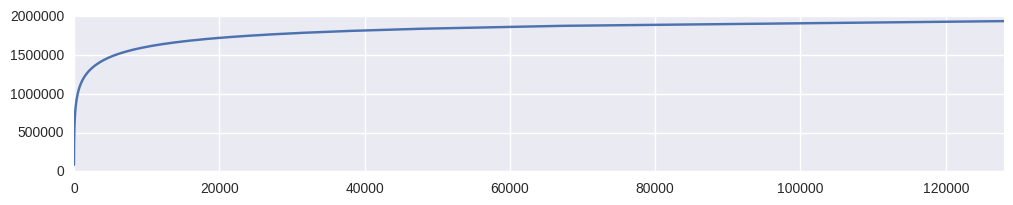

In [27]:
url_frequency = pd.Series([j for i in X_urls for j in i]).value_counts()
url_frequency.index = range(len(url_frequency))
url_frequency.cumsum().plot(figsize=(12,2))

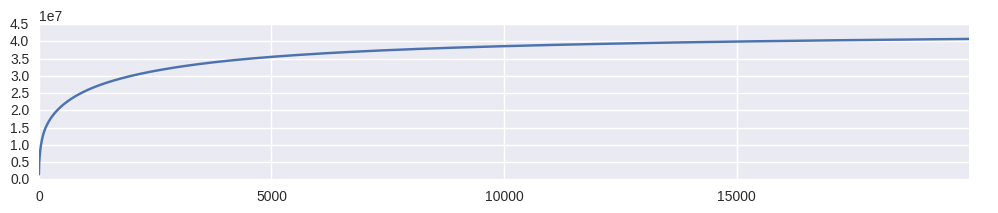

In [28]:
title_frequency = pd.Series([j for i in X_title for j in i.split()]).value_counts()
title_frequency.index = range(len(title_frequency))
title_frequency[0:20000].cumsum().plot(figsize=(12,2))

In [29]:
X_urls = map(lambda x: ' '.join(x), X_urls)
hw_u = HashingVectorizer(n_features=1000, non_negative=True).fit(X_urls)
X_urls = hw_u.transform(X_urls)

In [30]:
X_urls.shape

(108573, 1000)

In [31]:
#X_title = map(lambda x: ' '.join(x), X_title)
hw_t = HashingVectorizer(n_features=1000, non_negative=True, decode_error='ignore').fit(X_title)
X_title = hw_t.transform(X_title)
print 1

1


In [40]:
X_title.shape

(108573, 1000)

In [33]:
%%time

transformer = sklearn.decomposition.NMF(n_components=100)
X_nmf = transformer.fit_transform(X_urls)

CPU times: user 17min 55s, sys: 11 s, total: 18min 6s
Wall time: 11min 28s


In [34]:
X_nmf.shape

(108573, 100)

In [ ]:
clust = AgglomerativeClustering(5)
clust.fit(X_nmf[:10000]) 

## Холдаут

In [37]:
itrain, itest = cross_validation.train_test_split(range(X_urls.shape[0]), test_size=1./3, random_state=42)
len(itrain), len(itest)

(72382, 36191)

## Обучение модели

Константный бейзлайн

In [68]:
rmse(y[itest], np.mean(y[itrain]))


10.772915115482986

In [69]:
print(min(y),np.mean(y),max(y))
for i  in xrange(1,6):
    print i, y[y == i].size

(16, 36.285734022270731, 64)
1 0
2 0
3 0
4 0
5 0


Линейная модель на обычных фичах

In [67]:
y = train_df.age.values

In [89]:
reg1 = LinearRegression()
reg1.fit(X_urls[itrain, :], y[itrain])

pred_X_urls = reg1.predict(X_urls[itest, :])
print(rmse(y[itest], pred_X_urls))

10.0981521299


Линейная модель на NMF от обычных фичей

In [71]:
reg = LinearRegression()
reg.fit(X_nmf[itrain, :], y[itrain])

pred_X_nmf = reg.predict(X_nmf[itest, :])
print(rmse(y[itest], pred_X_nmf))

10.2421827729


In [72]:
reg2 = sklearn.ensemble.ExtraTreesRegressor(n_estimators=100, max_leaf_nodes=10)
reg2.fit(X_title[itrain, :], y[itrain])

print rmse(reg2.predict(X_title[itrain, :]), y[itrain])
pred_X_title = reg2.predict(X_title[itest, :])
print(rmse(y[itest], pred_X_title))

10.2857097797
10.3606430539


In [90]:
reg3 = LinearRegression()
reg3.fit(X_title[itrain, :], y[itrain])

print rmse(reg3.predict(X_title[itrain, :]), y[itrain])
pred_X_title = reg3.predict(X_title[itest, :])
print(rmse(y[itest], pred_X_title))

9.9057200552
10.1387454485


Линейная комбинация

9.95417939845
46


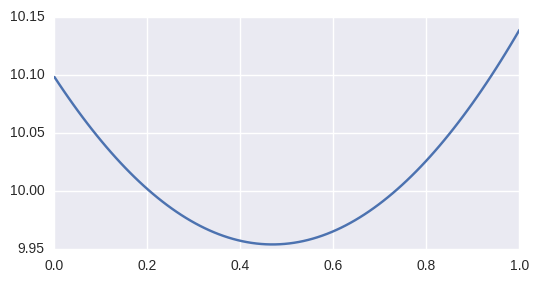

In [91]:
error = []
for w in np.linspace(0, 1, 100):
     error += [rmse(y[itest], pred_X_title * w + (1-w) * pred_X_urls)]

pd.Series(error, index=np.linspace(0, 1, 100)).plot(figsize=(6,3))
print(min(error))
print np.argmin(error)

In [ ]:
clas = sklearn.ensemble.RandomForestClassifier(n_estimators=1000 ,max_depth=5)
clas.fit(X_nmf[itrain, :], y[itrain])

pred_X = clas.predict(X_nmf[itrain, :])
print(rmse(y[itrain], pred_X))

pred_X = clas.predict(X_nmf[itest, :])
print(rmse(y[itest], pred_X))

In [ ]:
clas = sklearn.multiclass.OneVsRestClassifier(sklearn.ensemble.GradientBoostingClassifier(n_estimators=100 ,max_depth=3))
clas.fit(X_nmf[itrain, :], y[itrain])

pred_X = clas.predict(X_nmf[itrain, :])
print(rmse(y[itrain], pred_X))

pred_X = clas.predict(X_nmf[itest, :])
print(rmse(y[itest], pred_X))


In [63]:
reg = sklearn.ensemble.RandomForestRegressor(n_estimators=100 ,max_depth=10)
reg.fit(X_nmf[itrain, :], y[itrain])

pred_X_nmf = reg.predict(X_nmf[itrain, :])
print(rmse(y[itrain], pred_X_nmf))

pred_X_nmf = reg.predict(X_nmf[itest, :])
print(rmse(y[itest], pred_X_nmf))

9.46016686385
10.1185003515


In [65]:
reg = sklearn.ensemble.GradientBoostingRegressor(n_estimators=100 ,max_leaf_nodes=5)
reg.fit(X_nmf[itrain, :], y[itrain])

pred_X_nmf = reg.predict(X_nmf[itrain, :])
print(rmse(y[itrain], pred_X_nmf))

pred_X_nmf = reg.predict(X_nmf[itest, :])
print(rmse(y[itest], pred_X_nmf))

1.01700199037
1.029063568


In [62]:
reg2 = sklearn.ensemble.GradientBoostingRegressor(n_estimators=10 ,max_depth=6)
reg2.fit(X_nmf[itrain, :], y[itrain])

pred_X_nmf = reg2.predict(X_nmf[itrain, :])
print(rmse(y[itrain], pred_X_nmf))

pred_X_nmf = reg2.predict(X_nmf[itest, :])
print(rmse(y[itest], pred_X_nmf))

10.104669539
10.2632022269


In [ ]:
regn = sklearn.neighbors.KNeighborsRegressor(n_neighbors=15000, p = 2, weights='distance')
regn.fit(X[itrain, :], y[itrain])

#pred_X = regn.predict(X[itrain, :])
#print(rmse(y[itrain], pred_X))

pred_X = regn.predict(X[itest[-100:], :])
print(rmse(y[itest[-100:]], pred_X))

In [ ]:
clus = sklearn.cluster.AgglomerativeClustering(n_clusters = 5)
labels = clus.fit_predict(X_urls.todense())



In [47]:
sklearn.ensemble.BaggingClassifier()

array([[  4.30969460e-02,   2.77308718e-02,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  5.38117949e-02,   6.57853775e-03,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  3.30163597e-02,   0.00000000e+00,   1.41488604e-04, ...,
          6.62846773e-03,   0.00000000e+00,   4.32988414e-04],
       ..., 
       [  5.14327534e-02,   2.11803099e-02,   0.00000000e+00, ...,
          0.00000000e+00,   2.78066015e-05,   1.78324860e-04],
       [  3.85598927e-02,   0.00000000e+00,   3.94825907e-05, ...,
          6.16175431e-06,   0.00000000e+00,   0.00000000e+00],
       [  5.08006836e-02,   8.59077224e-03,   4.08887741e-04, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

In [ ]:
import lasagne

input_X = T.tensor4("X")

#размерность входа (None означает "может изменяться")
input_shape = (None,1,28,28)

target_y = T.vector("target Y integer",dtype='int32')

In [ ]:
#входной слой (вспомогательный)
input_layer = lasagne.layers.InputLayer(shape = input_shape,input_var=input_X)

drop_input = lasagne.layers.DropoutLayer(input_layer, p = 0.8)
dense_1 = lasagne.layers.DenseLayer(input_layer, num_units = 2000, nonlinearity = leaky_rectify)
drop_1 = lasagne.layers.DropoutLayer(dense_1, p = 0.5)
dense_2 = lasagne.layers.DenseLayer(drop_1, num_units = 2000, nonlinearity = leaky_rectify)
drop_2 = lasagne.layers.DropoutLayer(dense_2, p = 0.5)
#dense_3 = lasagne.layers.DenseLayer(drop_2, num_units = 150, nonlinearity = leaky_rectify)
#drop_3 = lasagne.layers.DropoutLayer(dense_3, p = 0.8)
#dense_4 = lasagne.layers.DenseLayer(drop_3, num_units = 75, nonlinearity = leaky_rectify)
#drop_4 = lasagne.layers.DropoutLayer(dense_4, p = 0.8)
#ВЫХОДНОЙ полносвязный слой, который принимает на вход dense_1 и имеет 10 нейронов -по нейрону на цифру
#нелинейность - softmax - чтобы вероятности всех цифр давали в сумме 1
dense_output = lasagne.layers.DenseLayer(drop_2,num_units = 10,
                                        nonlinearity = lasagne.nonlinearities.softmax,
                                        name='output')

In [ ]:
#предсказание нейронки (theano-преобразование)
y_predicted = lasagne.layers.get_output(dense_output)

In [ ]:
#все веса нейронки (shared-переменные)
all_weights = lasagne.layers.get_all_params(dense_output)
print all_weights

In [ ]:
#функция ошибки - средняя кроссэнтропия
penalty = lasagne.updates.total_norm_constraint(all_weights, 500)
loss = lasagne.objectives.categorical_crossentropy(y_predicted,target_y).mean() #+ np.mean(penalty)

#<возможно добавить регуляризатор>

accuracy = lasagne.objectives.categorical_accuracy(y_predicted,target_y).mean()

#сразу посчитать словарь обновлённых значений с шагом по градиенту, как раньше
updates_sgd = lasagne.updates.adadelta(loss, all_weights,learning_rate=1)

In [ ]:
#функция, которая обучает сеть на 1 шаг и возвращащет значение функции потерь и точности
train_fun = theano.function([input_X,target_y],[loss,accuracy],updates= updates_sgd)

#функция, которая считает точность
accuracy_fun = theano.function([input_X,target_y],accuracy)

In [ ]:
#итерации обучения

num_epochs = 10 #количество проходов по данным

batch_size = 150 #размер мини-батча

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size, shuffle = True):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

In [ ]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

In [39]:
from sklearn import pipeline, preprocessing, feature_extraction

In [56]:
# %%time

# обычный датасет
dataset1 = Dataset(X_urls[itrain, :], y[itrain], X_urls[itest, :]).to_dense()
# NMF
dataset2 = Dataset(X_nmf[itrain, :], y[itrain], X_nmf[itest, :]).to_dense()
# датасет тайтлов
#dataset3 = Dataset(X_title[itrain, :], y[itrain], X_title[itest, :]).to_dense()

# линейная модель на обычных данных
lr = Regressor(dataset=dataset1, 
                     estimator=linear_model.LinearRegression,
                     parameters={'normalize': True},
                     name='lr')

# линейная модель на TFIDF от обычных данных
def tfidf_lr_(X_train, y_train, X_test, y_test=None, random_state=8888):
    model = pipeline.Pipeline([('tfidf', feature_extraction.text.TfidfTransformer()), 
                                ('linear_model', linear_model.LinearRegression())])
    model.fit(X_train, y_train)
    return model.predict(X_test)

tfidf_lr = Regressor(dataset=dataset1,
                     estimator=tfidf_lr_,
                     name='tfidf_lr')

# ExtraTrees на NMF
rf = Regressor(dataset=dataset2, 
                     estimator=ensemble.ExtraTreesRegressor,
                     parameters={'n_estimators': 100, 'n_jobs': -1},
                     name='rf')

# Stack two models
# Returns new dataset with out-of-fold predictions
meta_pipeline = ModelsPipeline(lr, tfidf_lr, rf)
stack_ds = meta_pipeline.blend(proportion=0.2,seed=111)

# Train LinearRegression on stacked data (second stage)
stacker = Regressor(dataset=stack_ds, estimator=LinearRegression)
results = stacker.predict()

print(rmse(y[itest], results))

AttributeError: 'NoneType' object has no attribute 'hash'

### Делаю файл с предсказанием на тестовой выборке

In [77]:
urls_test_df = pd.read_csv('data/url_domain_test', header=None, delimiter='\t')
urls_test_df.columns = ['id', 'url', 'count']
urls_test_df = urls_test_df[['id', 'url']]
urls_test_df.tail()

,id,url
613383,06258377567D8500000004DF4B0DF601,vashaibolit.ru
613384,06258377567D8500000004DF4B0DF601,xn--80aag2bpgd.xn--p1ai
613385,06258377567D8500000004DF4B0DF601,xn--h1aeghn.xn--p1ai
613386,06258377567D8500000004DF4B0DF601,zoom.cnews.ru
613387,06258377567D8500000004DF4B0DF601,zvenigorod.superjob.ru


In [78]:
urls_test_df = pd.DataFrame(urls_test_df.groupby('id')['url'].apply(lambda x: x.tolist()))
urls_test_df['id'] = urls_test_df.index
urls_test_df.index = range(len(urls_test_df))
urls_test_df.columns = ['urls', 'id']

In [79]:
urls_test_df.tail()

,urls,id
19969,"[akusherstvo.ru, cat.pet2me.com, domik3.ru, ge...",06393B8756FE32ED000004DE11330B01
19970,"[free.drweb.ru, mail.rambler.ru, pevp.mos.ru, ...",06393B87570376CB000004D6801BDC01
19971,"[afisha.ru, formulalubvi.com, gazeta.ru, hh.ru...",06393D555702D3B2000004DE774F1901
19972,"[kirrail.org, lenta.ru, mail.rambler.ru, rambl...",06394267570511A900000540C88F9201
19973,"[help.rambler.ru, mail.rambler.ru, realtymag.r...",0639457C57020EB700006DD1885A0501


In [80]:
title_unify_test = pd.read_csv('data/title_unify_test', header=None, delimiter='\t')
title_unify_test.columns = ['id','words','count']
title_unify_test = title_unify_test[['id','words']]

In [81]:
title_unify_train.tail()

,words,id
114151,chanel афиша киев магазин cl merced для зажига...,E7DB77EB4EEFF6C73DD7EB5CD37CB7E3
114152,cosmopolitan ведущий гламурный гузеев журнал и...,E7DFB7DB4DDF3C7E785EDF7DF17AA76D
114153,4z7616051a 4z7616051d 4z7616052a allroad arnot...,E9B9D7D347EB1ACE5AAEEBFCE3FBCE7B
114154,ru онлайн попка порно секс азербайджан военный...,EBFAC66B4EE3FB96BA5DD7DDE3787FE7
114155,5d merced-benz видео драйв комплектация отзыв ...,F537AD6B46D31ABFF597EFDFE1BDDE71


In [82]:
title_unify_test = pd.DataFrame(title_unify_test.groupby('id')['words'].apply(lambda x: ' '.join(x)))
title_unify_test['id'] = title_unify_test.index
title_unify_test.index = range(len(title_unify_test))
title_unify_test.columns = ['words', 'id']

In [96]:
train_df = urls_test_df.merge(title_unify_test, on='id', how='left')

In [97]:
train_df.tail()

,urls,id,words
19969,"[akusherstvo.ru, cat.pet2me.com, domik3.ru, ge...",06393B8756FE32ED000004DE11330B01,10-метровый бессмертный вечный май москва огон...
19970,"[free.drweb.ru, mail.rambler.ru, pevp.mos.ru, ...",06393B87570376CB000004D6801BDC01,footer бесплатный надёжный почта рамблер элект...
19971,"[afisha.ru, formulalubvi.com, gazeta.ru, hh.ru...",06393D555702D3B2000004DE774F1901,co rambler карьер group retail x5 вакансия гла...
19972,"[kirrail.org, lenta.ru, mail.rambler.ru, rambl...",06394267570511A900000540C88F9201,lenta ru lenta ru война госдума день на отвест...
19973,"[help.rambler.ru, mail.rambler.ru, realtymag.r...",0639457C57020EB700006DD1885A0501,alenka844 rambler ru входящая рамблер-почта ак...


In [98]:
train_df = train_df[['id','urls','words']]
train_df.tail()

,id,urls,words
19969,06393B8756FE32ED000004DE11330B01,"[akusherstvo.ru, cat.pet2me.com, domik3.ru, ge...",10-метровый бессмертный вечный май москва огон...
19970,06393B87570376CB000004D6801BDC01,"[free.drweb.ru, mail.rambler.ru, pevp.mos.ru, ...",footer бесплатный надёжный почта рамблер элект...
19971,06393D555702D3B2000004DE774F1901,"[afisha.ru, formulalubvi.com, gazeta.ru, hh.ru...",co rambler карьер group retail x5 вакансия гла...
19972,06394267570511A900000540C88F9201,"[kirrail.org, lenta.ru, mail.rambler.ru, rambl...",lenta ru lenta ru война госдума день на отвест...
19973,0639457C57020EB700006DD1885A0501,"[help.rambler.ru, mail.rambler.ru, realtymag.r...",alenka844 rambler ru входящая рамблер-почта ак...


In [101]:
train_df = train_df[train_df.words == train_df.words]
len(train_df)

19955

In [102]:
X_urls_test = train_df.urls.values
X_urls_test = map(lambda x: ' '.join(x), X_urls_test)
X_urls_test = hw_u.transform(X_urls_test)

In [103]:
X_title_test = train_df.words.values
X_title_test = hw_t.transform(X_title_test)

In [104]:
y_test = 0.54*reg1.predict(X_urls_test) + 0.46*reg3.predict(X_title_test)

In [105]:
y_test

array([ 39.17342171,  43.08630566,  37.86144312, ...,  37.58127086,
        38.61216644,  41.74260893])

In [ ]:
X_test_nmf = transformer.transform(X_test)

In [ ]:
y_test = reg.predict(X_test_nmf)

In [ ]:
y_test

In [ ]:
k = 0
print(y_test[k])
print(urls_test_df.urls[k])
plt.plot(y_test)

In [107]:
answer = pd.DataFrame(y_test, train_df.id)
answer['Id'] = answer.index
answer.index = range(len(answer))
answer.columns = ['age', 'Id']
answer = answer[['Id', 'age']]
answer.tail()

,Id,age
19950,06393B8756FE32ED000004DE11330B01,36.037659
19951,06393B87570376CB000004D6801BDC01,36.595655
19952,06393D555702D3B2000004DE774F1901,37.581271
19953,06394267570511A900000540C88F9201,38.612166
19954,0639457C57020EB700006DD1885A0501,41.742609


In [ ]:
answer.to_csv(path_or_buf = 'submission1.csv',  index = False)

In [108]:
aaa = pd.read_csv('data/sample_submission.csv')
Set = set(aaa.Id.values)

Set2 = set(answer.Id.values)

dop = pd.DataFrame([[i,36] for i in (Set - Set2)], columns = ['Id','age'])

answer.append(dop).to_csv(path_or_buf = 'submission1.csv',  index = False)

In [ ]:
(* Helper, to avoid code repetition *)
SetAttributes[withMacros, HoldAllComplete];
withMacros[rules : {(_Rule | _RuleDelayed) ..}, code_] :=
  Unevaluated[code] /. rules;

SetAttributes[{StoreInNotebook, GetFromNotebook, RestoreFromNotebook, 
   ClearNotebookStorage}, HoldFirst];
SetAttributes[{StoreInNotebook, RestoreFromNotebook, 
   ClearNotebookStorage}, Listable];

withMacros[{cv[s_] :> 
   CurrentValue[
    EvaluationNotebook[], {TaggingRules, "Storage", 
     ToString@Unevaluated@s}]},

 StoreInNotebook[s_Symbol] := cv[s] = Compress[s];

 RestoreFromNotebook[s_Symbol] := (s = Uncompress@cv[s];);

 GetFromNotebook[s_Symbol] := Uncompress@cv[s];

 ClearNotebookStorage[] := 
  CurrentValue[EvaluationNotebook[], {TaggingRules, "Storage"}] = {};

 ClearNotebookStorage[s_Symbol] := cv[s] = {};
 ]